<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:00:42] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


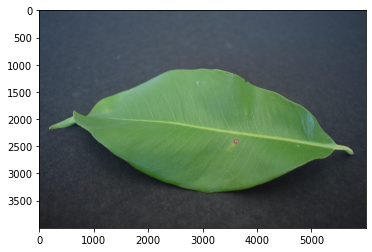

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

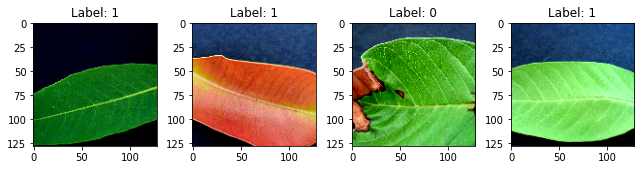

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:00:49] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:00:51] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2009232466241693 samples/sec                   batch loss = 1.0258433818817139 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2419620690109543 samples/sec                   batch loss = 0.5950207710266113 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2633924312042843 samples/sec                   batch loss = 1.0919058322906494 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2641840041075467 samples/sec                   batch loss = 0.5575868487358093 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.270182714078337 samples/sec                   batch loss = 0.4141530692577362 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2633696934939067 samples/sec                   batch loss = 0.5084280967712402 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.261137397936533 samples/sec                   batch loss = 0.5028883218765259 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2627625474734123 samples/sec                   batch loss = 0.7893359065055847 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2683427848614575 samples/sec                   batch loss = 0.39283278584480286 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.2641220895502596 samples/sec                   batch loss = 0.837002158164978 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.2607691156198393 samples/sec                   batch loss = 0.5300488471984863 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2628549367417707 samples/sec                   batch loss = 0.7679300904273987 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2576404968069521 samples/sec                   batch loss = 0.5709836483001709 | accuracy = 0.6192307692307693


Epoch[1] Batch[70] Speed: 1.2588889834337835 samples/sec                   batch loss = 0.6620893478393555 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2655986399874233 samples/sec                   batch loss = 1.783630609512329 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.26168595531567 samples/sec                   batch loss = 0.8721424341201782 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2598268344241506 samples/sec                   batch loss = 0.774732232093811 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.255540655697048 samples/sec                   batch loss = 0.6414764523506165 | accuracy = 0.6333333333333333


Epoch[1] Batch[95] Speed: 1.260842167394126 samples/sec                   batch loss = 0.4349272549152374 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.2605694271256442 samples/sec                   batch loss = 0.6121730804443359 | accuracy = 0.645


Epoch[1] Batch[105] Speed: 1.2607068719550247 samples/sec                   batch loss = 0.719829797744751 | accuracy = 0.6452380952380953


Epoch[1] Batch[110] Speed: 1.2609492494942025 samples/sec                   batch loss = 0.6511101722717285 | accuracy = 0.6431818181818182


Epoch[1] Batch[115] Speed: 1.2708173287047102 samples/sec                   batch loss = 0.7752077579498291 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.2618968177774355 samples/sec                   batch loss = 0.42472565174102783 | accuracy = 0.6375


Epoch[1] Batch[125] Speed: 1.2622608209427417 samples/sec                   batch loss = 0.613041877746582 | accuracy = 0.64


Epoch[1] Batch[130] Speed: 1.2655869926156813 samples/sec                   batch loss = 0.5078790783882141 | accuracy = 0.6442307692307693


Epoch[1] Batch[135] Speed: 1.2656259453222232 samples/sec                   batch loss = 0.6352288722991943 | accuracy = 0.6462962962962963


Epoch[1] Batch[140] Speed: 1.2627599812978147 samples/sec                   batch loss = 0.8619901537895203 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.260895611407753 samples/sec                   batch loss = 0.4439563751220703 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2694004212566485 samples/sec                   batch loss = 1.3754065036773682 | accuracy = 0.6433333333333333


Epoch[1] Batch[155] Speed: 1.2620602799229759 samples/sec                   batch loss = 1.358543872833252 | accuracy = 0.6483870967741936


Epoch[1] Batch[160] Speed: 1.2634374333535356 samples/sec                   batch loss = 0.24955885112285614 | accuracy = 0.65


Epoch[1] Batch[165] Speed: 1.26382288959662 samples/sec                   batch loss = 0.3431367576122284 | accuracy = 0.6530303030303031


Epoch[1] Batch[170] Speed: 1.2632483127038814 samples/sec                   batch loss = 0.5127400159835815 | accuracy = 0.6529411764705882


Epoch[1] Batch[175] Speed: 1.259914442269559 samples/sec                   batch loss = 0.7768678069114685 | accuracy = 0.6528571428571428


Epoch[1] Batch[180] Speed: 1.2583297363481756 samples/sec                   batch loss = 0.8913754820823669 | accuracy = 0.6513888888888889


Epoch[1] Batch[185] Speed: 1.2631492086991967 samples/sec                   batch loss = 0.2656330466270447 | accuracy = 0.6513513513513514


Epoch[1] Batch[190] Speed: 1.2631635692566043 samples/sec                   batch loss = 0.3470606207847595 | accuracy = 0.6513157894736842


Epoch[1] Batch[195] Speed: 1.2557567062397963 samples/sec                   batch loss = 0.4635041058063507 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2585234290357428 samples/sec                   batch loss = 0.52799391746521 | accuracy = 0.65


Epoch[1] Batch[205] Speed: 1.2621021489914332 samples/sec                   batch loss = 0.3226245939731598 | accuracy = 0.651219512195122


Epoch[1] Batch[210] Speed: 1.259783129665885 samples/sec                   batch loss = 0.614895761013031 | accuracy = 0.6511904761904762


Epoch[1] Batch[215] Speed: 1.2610139813886143 samples/sec                   batch loss = 0.7909071445465088 | accuracy = 0.6523255813953488


Epoch[1] Batch[220] Speed: 1.262527738077894 samples/sec                   batch loss = 0.4352474808692932 | accuracy = 0.6556818181818181


Epoch[1] Batch[225] Speed: 1.2626370071831734 samples/sec                   batch loss = 0.40763136744499207 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.2618659716577585 samples/sec                   batch loss = 0.4015398919582367 | accuracy = 0.658695652173913


Epoch[1] Batch[235] Speed: 1.2616836781580152 samples/sec                   batch loss = 0.6293063759803772 | accuracy = 0.6553191489361702


Epoch[1] Batch[240] Speed: 1.2606417926866436 samples/sec                   batch loss = 0.6346966028213501 | accuracy = 0.65625


Epoch[1] Batch[245] Speed: 1.2598220097240156 samples/sec                   batch loss = 0.18231087923049927 | accuracy = 0.6561224489795918


Epoch[1] Batch[250] Speed: 1.2597739539437918 samples/sec                   batch loss = 0.3830665946006775 | accuracy = 0.658


Epoch[1] Batch[255] Speed: 1.2622813344121435 samples/sec                   batch loss = 0.541827380657196 | accuracy = 0.6598039215686274


Epoch[1] Batch[260] Speed: 1.258272074264471 samples/sec                   batch loss = 0.9206185340881348 | accuracy = 0.6605769230769231


Epoch[1] Batch[265] Speed: 1.2604505724093875 samples/sec                   batch loss = 0.5757333636283875 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.2588057683279483 samples/sec                   batch loss = 0.41201984882354736 | accuracy = 0.6601851851851852


Epoch[1] Batch[275] Speed: 1.2455045082050273 samples/sec                   batch loss = 1.1883865594863892 | accuracy = 0.6590909090909091


Epoch[1] Batch[280] Speed: 1.2512585326984318 samples/sec                   batch loss = 0.983892560005188 | accuracy = 0.6589285714285714


Epoch[1] Batch[285] Speed: 1.2593331092479363 samples/sec                   batch loss = 1.5427985191345215 | accuracy = 0.6596491228070176


Epoch[1] Batch[290] Speed: 1.2615040932374642 samples/sec                   batch loss = 0.551863968372345 | accuracy = 0.6577586206896552


Epoch[1] Batch[295] Speed: 1.261656447784587 samples/sec                   batch loss = 0.5374799966812134 | accuracy = 0.6567796610169492


Epoch[1] Batch[300] Speed: 1.2589757995654087 samples/sec                   batch loss = 0.7881081104278564 | accuracy = 0.6575


Epoch[1] Batch[305] Speed: 1.2614310595861924 samples/sec                   batch loss = 0.4797419607639313 | accuracy = 0.6557377049180327


Epoch[1] Batch[310] Speed: 1.2590571474156302 samples/sec                   batch loss = 0.4436127543449402 | accuracy = 0.657258064516129


Epoch[1] Batch[315] Speed: 1.2690277777882832 samples/sec                   batch loss = 0.5289592146873474 | accuracy = 0.6587301587301587


Epoch[1] Batch[320] Speed: 1.2651551410735016 samples/sec                   batch loss = 0.3640986680984497 | accuracy = 0.66015625


Epoch[1] Batch[325] Speed: 1.2610461128643162 samples/sec                   batch loss = 0.41146421432495117 | accuracy = 0.66


Epoch[1] Batch[330] Speed: 1.2603662985831448 samples/sec                   batch loss = 0.5298640131950378 | accuracy = 0.6613636363636364


Epoch[1] Batch[335] Speed: 1.2656624179219775 samples/sec                   batch loss = 0.6232492327690125 | accuracy = 0.6626865671641791


Epoch[1] Batch[340] Speed: 1.2614008052651395 samples/sec                   batch loss = 0.7884608507156372 | accuracy = 0.6639705882352941


Epoch[1] Batch[345] Speed: 1.2634842466019587 samples/sec                   batch loss = 0.24303258955478668 | accuracy = 0.6659420289855073


Epoch[1] Batch[350] Speed: 1.2618427194259603 samples/sec                   batch loss = 0.5009980797767639 | accuracy = 0.6642857142857143


Epoch[1] Batch[355] Speed: 1.2674189293307272 samples/sec                   batch loss = 0.4255761504173279 | accuracy = 0.6654929577464789


Epoch[1] Batch[360] Speed: 1.26623651758874 samples/sec                   batch loss = 0.48249614238739014 | accuracy = 0.6659722222222222


Epoch[1] Batch[365] Speed: 1.260285728193439 samples/sec                   batch loss = 1.688267469406128 | accuracy = 0.6643835616438356


Epoch[1] Batch[370] Speed: 1.261284733185743 samples/sec                   batch loss = 0.2628500461578369 | accuracy = 0.6668918918918919


Epoch[1] Batch[375] Speed: 1.2632971095438508 samples/sec                   batch loss = 0.591627299785614 | accuracy = 0.668


Epoch[1] Batch[380] Speed: 1.2608290913572657 samples/sec                   batch loss = 0.22157339751720428 | accuracy = 0.6671052631578948


Epoch[1] Batch[385] Speed: 1.2654822713700034 samples/sec                   batch loss = 0.339286208152771 | accuracy = 0.6688311688311688


Epoch[1] Batch[390] Speed: 1.2402297954996286 samples/sec                   batch loss = 0.4037218391895294 | accuracy = 0.6692307692307692


Epoch[1] Batch[395] Speed: 1.2459920745318993 samples/sec                   batch loss = 0.7826942205429077 | accuracy = 0.669620253164557


Epoch[1] Batch[400] Speed: 1.250141931047628 samples/sec                   batch loss = 0.9810827970504761 | accuracy = 0.67


Epoch[1] Batch[405] Speed: 1.2616632789873314 samples/sec                   batch loss = 0.48415711522102356 | accuracy = 0.6703703703703704


Epoch[1] Batch[410] Speed: 1.2595970872802378 samples/sec                   batch loss = 0.7615463733673096 | accuracy = 0.6707317073170732


Epoch[1] Batch[415] Speed: 1.262505221490923 samples/sec                   batch loss = 0.5294345617294312 | accuracy = 0.6710843373493975


Epoch[1] Batch[420] Speed: 1.2763959188114007 samples/sec                   batch loss = 0.5359339714050293 | accuracy = 0.6702380952380952


Epoch[1] Batch[425] Speed: 1.261196176212479 samples/sec                   batch loss = 0.9457332491874695 | accuracy = 0.67


Epoch[1] Batch[430] Speed: 1.2596782317009259 samples/sec                   batch loss = 0.47842931747436523 | accuracy = 0.6703488372093023


Epoch[1] Batch[435] Speed: 1.2647636278656023 samples/sec                   batch loss = 0.6267896890640259 | accuracy = 0.6718390804597701


Epoch[1] Batch[440] Speed: 1.267380823582211 samples/sec                   batch loss = 1.6338557004928589 | accuracy = 0.6715909090909091


Epoch[1] Batch[445] Speed: 1.2662080391439436 samples/sec                   batch loss = 0.34831491112709045 | accuracy = 0.6719101123595506


Epoch[1] Batch[450] Speed: 1.264931648428171 samples/sec                   batch loss = 1.1117331981658936 | accuracy = 0.6738888888888889


Epoch[1] Batch[455] Speed: 1.2651330076771932 samples/sec                   batch loss = 0.37060487270355225 | accuracy = 0.6741758241758242


Epoch[1] Batch[460] Speed: 1.2609153224003304 samples/sec                   batch loss = 0.4538857042789459 | accuracy = 0.6755434782608696


Epoch[1] Batch[465] Speed: 1.2617138511640527 samples/sec                   batch loss = 0.3839340806007385 | accuracy = 0.6741935483870968


Epoch[1] Batch[470] Speed: 1.2597671431849555 samples/sec                   batch loss = 0.7511678338050842 | accuracy = 0.675531914893617


Epoch[1] Batch[475] Speed: 1.2536590239310017 samples/sec                   batch loss = 0.5935022234916687 | accuracy = 0.6763157894736842


Epoch[1] Batch[480] Speed: 1.2511767898171613 samples/sec                   batch loss = 0.287107914686203 | accuracy = 0.678125


Epoch[1] Batch[485] Speed: 1.2519180918676815 samples/sec                   batch loss = 0.5759117603302002 | accuracy = 0.6783505154639176


Epoch[1] Batch[490] Speed: 1.2593813204709996 samples/sec                   batch loss = 0.27441009879112244 | accuracy = 0.6801020408163265


Epoch[1] Batch[495] Speed: 1.2587427739701618 samples/sec                   batch loss = 0.23933292925357819 | accuracy = 0.6797979797979798


Epoch[1] Batch[500] Speed: 1.252802827413455 samples/sec                   batch loss = 0.39654669165611267 | accuracy = 0.68


Epoch[1] Batch[505] Speed: 1.258552223731202 samples/sec                   batch loss = 0.5793729424476624 | accuracy = 0.6801980198019802


Epoch[1] Batch[510] Speed: 1.2498824595182834 samples/sec                   batch loss = 0.7008743286132812 | accuracy = 0.6813725490196079


Epoch[1] Batch[515] Speed: 1.2408120665404545 samples/sec                   batch loss = 0.6337374448776245 | accuracy = 0.6820388349514563


Epoch[1] Batch[520] Speed: 1.2437074860189419 samples/sec                   batch loss = 1.1643619537353516 | accuracy = 0.68125


Epoch[1] Batch[525] Speed: 1.2562238324389552 samples/sec                   batch loss = 0.4522988200187683 | accuracy = 0.6795238095238095


Epoch[1] Batch[530] Speed: 1.2556880957930163 samples/sec                   batch loss = 0.7504046559333801 | accuracy = 0.680188679245283


Epoch[1] Batch[535] Speed: 1.2677911074103805 samples/sec                   batch loss = 0.5158137679100037 | accuracy = 0.680841121495327


Epoch[1] Batch[540] Speed: 1.2625909218194833 samples/sec                   batch loss = 0.4867161214351654 | accuracy = 0.6810185185185185


Epoch[1] Batch[545] Speed: 1.266306572368787 samples/sec                   batch loss = 0.6652800440788269 | accuracy = 0.6821100917431193


Epoch[1] Batch[550] Speed: 1.2746584195700286 samples/sec                   batch loss = 0.4087042212486267 | accuracy = 0.6845454545454546


Epoch[1] Batch[555] Speed: 1.2615905115056896 samples/sec                   batch loss = 0.7216235995292664 | accuracy = 0.6851351351351351


Epoch[1] Batch[560] Speed: 1.2658848316927545 samples/sec                   batch loss = 0.6758115887641907 | accuracy = 0.684375


Epoch[1] Batch[565] Speed: 1.266553976495712 samples/sec                   batch loss = 0.3027472198009491 | accuracy = 0.6836283185840708


Epoch[1] Batch[570] Speed: 1.273582725712816 samples/sec                   batch loss = 0.21761642396450043 | accuracy = 0.6846491228070175


Epoch[1] Batch[575] Speed: 1.266450720362419 samples/sec                   batch loss = 0.4360378086566925 | accuracy = 0.6856521739130435


Epoch[1] Batch[580] Speed: 1.262691838895029 samples/sec                   batch loss = 0.8274126648902893 | accuracy = 0.6866379310344828


Epoch[1] Batch[585] Speed: 1.261353292787403 samples/sec                   batch loss = 0.4912663400173187 | accuracy = 0.6867521367521368


Epoch[1] Batch[590] Speed: 1.2605894120718835 samples/sec                   batch loss = 0.45881420373916626 | accuracy = 0.686864406779661


Epoch[1] Batch[595] Speed: 1.2614866402713052 samples/sec                   batch loss = 0.35084068775177 | accuracy = 0.6873949579831933


Epoch[1] Batch[600] Speed: 1.2567056145261524 samples/sec                   batch loss = 0.5244772434234619 | accuracy = 0.6879166666666666


Epoch[1] Batch[605] Speed: 1.252404336038667 samples/sec                   batch loss = 0.21765875816345215 | accuracy = 0.687603305785124


Epoch[1] Batch[610] Speed: 1.2574555579089917 samples/sec                   batch loss = 0.4029832184314728 | accuracy = 0.6885245901639344


Epoch[1] Batch[615] Speed: 1.2537963713536067 samples/sec                   batch loss = 0.4958939254283905 | accuracy = 0.6882113821138212


Epoch[1] Batch[620] Speed: 1.2571653455747704 samples/sec                   batch loss = 0.501389741897583 | accuracy = 0.6895161290322581


Epoch[1] Batch[625] Speed: 1.2593805641880227 samples/sec                   batch loss = 0.5007731318473816 | accuracy = 0.6896


Epoch[1] Batch[630] Speed: 1.2466500750974951 samples/sec                   batch loss = 0.3069608509540558 | accuracy = 0.6904761904761905


Epoch[1] Batch[635] Speed: 1.2372557185190616 samples/sec                   batch loss = 0.5382404923439026 | accuracy = 0.6913385826771653


Epoch[1] Batch[640] Speed: 1.2481954519310325 samples/sec                   batch loss = 0.625770628452301 | accuracy = 0.6921875


Epoch[1] Batch[645] Speed: 1.2570210430870128 samples/sec                   batch loss = 0.5311952233314514 | accuracy = 0.6926356589147287


Epoch[1] Batch[650] Speed: 1.2565474890494461 samples/sec                   batch loss = 0.35773417353630066 | accuracy = 0.693076923076923


Epoch[1] Batch[655] Speed: 1.2558222221157649 samples/sec                   batch loss = 0.3730461299419403 | accuracy = 0.6938931297709924


Epoch[1] Batch[660] Speed: 1.2590325813355194 samples/sec                   batch loss = 0.4251289963722229 | accuracy = 0.693939393939394


Epoch[1] Batch[665] Speed: 1.2603757669904196 samples/sec                   batch loss = 0.5344563722610474 | accuracy = 0.6947368421052632


Epoch[1] Batch[670] Speed: 1.258357767125881 samples/sec                   batch loss = 0.4400295913219452 | accuracy = 0.6958955223880597


Epoch[1] Batch[675] Speed: 1.261896533037127 samples/sec                   batch loss = 0.18664826452732086 | accuracy = 0.6962962962962963


Epoch[1] Batch[680] Speed: 1.2591202677402935 samples/sec                   batch loss = 0.8473645448684692 | accuracy = 0.6974264705882353


Epoch[1] Batch[685] Speed: 1.2527868305028198 samples/sec                   batch loss = 0.32656577229499817 | accuracy = 0.6974452554744526


Epoch[1] Batch[690] Speed: 1.256967927014835 samples/sec                   batch loss = 0.2926085591316223 | accuracy = 0.6978260869565217


Epoch[1] Batch[695] Speed: 1.261324180123525 samples/sec                   batch loss = 0.6187253594398499 | accuracy = 0.697841726618705


Epoch[1] Batch[700] Speed: 1.258958983318727 samples/sec                   batch loss = 0.573639988899231 | accuracy = 0.6985714285714286


Epoch[1] Batch[705] Speed: 1.2566073461561507 samples/sec                   batch loss = 1.3453503847122192 | accuracy = 0.6982269503546099


Epoch[1] Batch[710] Speed: 1.2478939039787869 samples/sec                   batch loss = 0.5242841839790344 | accuracy = 0.696830985915493


Epoch[1] Batch[715] Speed: 1.2463632543829046 samples/sec                   batch loss = 1.5796986818313599 | accuracy = 0.6954545454545454


Epoch[1] Batch[720] Speed: 1.2470484348357385 samples/sec                   batch loss = 0.24774348735809326 | accuracy = 0.6954861111111111


Epoch[1] Batch[725] Speed: 1.2528211635562099 samples/sec                   batch loss = 0.4179477393627167 | accuracy = 0.6951724137931035


Epoch[1] Batch[730] Speed: 1.2487599460547412 samples/sec                   batch loss = 0.31782037019729614 | accuracy = 0.6945205479452055


Epoch[1] Batch[735] Speed: 1.2504706626902355 samples/sec                   batch loss = 0.322223037481308 | accuracy = 0.6952380952380952


Epoch[1] Batch[740] Speed: 1.2440565494540778 samples/sec                   batch loss = 0.5483346581459045 | accuracy = 0.6959459459459459


Epoch[1] Batch[745] Speed: 1.248375540339415 samples/sec                   batch loss = 0.3082197904586792 | accuracy = 0.6959731543624161


Epoch[1] Batch[750] Speed: 1.2588184246266942 samples/sec                   batch loss = 0.5805453062057495 | accuracy = 0.6963333333333334


Epoch[1] Batch[755] Speed: 1.2304514063760428 samples/sec                   batch loss = 0.4591689109802246 | accuracy = 0.6963576158940398


Epoch[1] Batch[760] Speed: 1.2287023877546448 samples/sec                   batch loss = 0.7130250930786133 | accuracy = 0.6957236842105263


Epoch[1] Batch[765] Speed: 1.248017736397083 samples/sec                   batch loss = 0.30793920159339905 | accuracy = 0.696078431372549


Epoch[1] Batch[770] Speed: 1.2557955261559821 samples/sec                   batch loss = 0.8934655785560608 | accuracy = 0.6964285714285714


Epoch[1] Batch[775] Speed: 1.2592866030954168 samples/sec                   batch loss = 0.3088410198688507 | accuracy = 0.6961290322580646


Epoch[1] Batch[780] Speed: 1.2555035427089463 samples/sec                   batch loss = 0.2619311809539795 | accuracy = 0.6974358974358974


Epoch[1] Batch[785] Speed: 1.259734698497641 samples/sec                   batch loss = 0.5599781274795532 | accuracy = 0.6984076433121019


[Epoch 1] training: accuracy=0.6989213197969543
[Epoch 1] time cost: 653.9307177066803
[Epoch 1] validation: validation accuracy=0.7622222222222222


Epoch[2] Batch[5] Speed: 1.2520089944684556 samples/sec                   batch loss = 0.3113669157028198 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2556642248751386 samples/sec                   batch loss = 0.43472808599472046 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2564383303941677 samples/sec                   batch loss = 0.23261801898479462 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2579041428952311 samples/sec                   batch loss = 0.595320463180542 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.2596991342298502 samples/sec                   batch loss = 0.6584386229515076 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2568827999784842 samples/sec                   batch loss = 0.18011370301246643 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2608073933148385 samples/sec                   batch loss = 0.3814621865749359 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2596665038889459 samples/sec                   batch loss = 0.4882744252681732 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2637302634606782 samples/sec                   batch loss = 0.6750508546829224 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2596781371209236 samples/sec                   batch loss = 0.24538497626781464 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2548066959159436 samples/sec                   batch loss = 0.33402568101882935 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2603860877163935 samples/sec                   batch loss = 0.6886160373687744 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.2548313789220362 samples/sec                   batch loss = 0.5553210377693176 | accuracy = 0.7576923076923077


Epoch[2] Batch[70] Speed: 1.2519557405726194 samples/sec                   batch loss = 0.4668058156967163 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2574825129958924 samples/sec                   batch loss = 1.4944525957107544 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2553126568933564 samples/sec                   batch loss = 0.27740684151649475 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2567185110373251 samples/sec                   batch loss = 0.3259164094924927 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2532116824088604 samples/sec                   batch loss = 0.21417906880378723 | accuracy = 0.7527777777777778


Epoch[2] Batch[95] Speed: 1.2504240632244188 samples/sec                   batch loss = 0.37145593762397766 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2523837683837225 samples/sec                   batch loss = 0.8918131589889526 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.2546756013196771 samples/sec                   batch loss = 0.7829024791717529 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2365905506593529 samples/sec                   batch loss = 0.6667650938034058 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2329677077884311 samples/sec                   batch loss = 0.6854649782180786 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2617749606664 samples/sec                   batch loss = 1.6980537176132202 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2553012920001816 samples/sec                   batch loss = 0.7738373279571533 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2551481208332156 samples/sec                   batch loss = 0.4349997937679291 | accuracy = 0.7576923076923077


Epoch[2] Batch[135] Speed: 1.2576378571332192 samples/sec                   batch loss = 0.3289736807346344 | accuracy = 0.7555555555555555


Epoch[2] Batch[140] Speed: 1.2559202737072954 samples/sec                   batch loss = 0.5525566339492798 | accuracy = 0.7553571428571428


Epoch[2] Batch[145] Speed: 1.2539258764980006 samples/sec                   batch loss = 0.3224356472492218 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.2517426768922713 samples/sec                   batch loss = 0.9364801049232483 | accuracy = 0.755


Epoch[2] Batch[155] Speed: 1.253306517984011 samples/sec                   batch loss = 0.7811374664306641 | accuracy = 0.7548387096774194


Epoch[2] Batch[160] Speed: 1.2549656977716175 samples/sec                   batch loss = 0.3316679894924164 | accuracy = 0.75625


Epoch[2] Batch[165] Speed: 1.2576412510014825 samples/sec                   batch loss = 0.39590567350387573 | accuracy = 0.7560606060606061


Epoch[2] Batch[170] Speed: 1.2565279143777537 samples/sec                   batch loss = 0.6631606817245483 | accuracy = 0.7573529411764706


Epoch[2] Batch[175] Speed: 1.256069119522381 samples/sec                   batch loss = 0.4192650318145752 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2509236039765692 samples/sec                   batch loss = 0.4990481436252594 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2582382910798602 samples/sec                   batch loss = 0.2278958559036255 | accuracy = 0.754054054054054


Epoch[2] Batch[190] Speed: 1.2643811232898536 samples/sec                   batch loss = 0.3256813883781433 | accuracy = 0.7526315789473684


Epoch[2] Batch[195] Speed: 1.2542926092337086 samples/sec                   batch loss = 0.5276536345481873 | accuracy = 0.7487179487179487


Epoch[2] Batch[200] Speed: 1.252646711286607 samples/sec                   batch loss = 0.5513795614242554 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.255982327687013 samples/sec                   batch loss = 0.43227025866508484 | accuracy = 0.7451219512195122


Epoch[2] Batch[210] Speed: 1.2562719940240052 samples/sec                   batch loss = 0.32034924626350403 | accuracy = 0.7452380952380953


Epoch[2] Batch[215] Speed: 1.259832889002094 samples/sec                   batch loss = 0.47505179047584534 | accuracy = 0.7465116279069768


Epoch[2] Batch[220] Speed: 1.2495095531472646 samples/sec                   batch loss = 0.6939867734909058 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2535725648300948 samples/sec                   batch loss = 0.29274624586105347 | accuracy = 0.7433333333333333


Epoch[2] Batch[230] Speed: 1.2365840794116008 samples/sec                   batch loss = 0.5445306897163391 | accuracy = 0.7434782608695653


Epoch[2] Batch[235] Speed: 1.2366167097736203 samples/sec                   batch loss = 0.4668441414833069 | accuracy = 0.7436170212765958


Epoch[2] Batch[240] Speed: 1.2374642436666057 samples/sec                   batch loss = 0.2821089029312134 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.2473917713649616 samples/sec                   batch loss = 0.5855737328529358 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.2499900163017401 samples/sec                   batch loss = 0.5807508230209351 | accuracy = 0.746


Epoch[2] Batch[255] Speed: 1.2594332225603873 samples/sec                   batch loss = 0.5213350653648376 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.2608406513179813 samples/sec                   batch loss = 0.15744023025035858 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2607644731861611 samples/sec                   batch loss = 0.2810622751712799 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2613568964027846 samples/sec                   batch loss = 0.3698634207248688 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.2582139456637362 samples/sec                   batch loss = 0.34695979952812195 | accuracy = 0.7454545454545455


Epoch[2] Batch[280] Speed: 1.2611486791484976 samples/sec                   batch loss = 0.21605350077152252 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.257780321078086 samples/sec                   batch loss = 0.29592376947402954 | accuracy = 0.743859649122807


Epoch[2] Batch[290] Speed: 1.2592156216682573 samples/sec                   batch loss = 0.389527291059494 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2643979894092487 samples/sec                   batch loss = 0.3965698778629303 | accuracy = 0.7415254237288136


Epoch[2] Batch[300] Speed: 1.2544632993268516 samples/sec                   batch loss = 0.3279127776622772 | accuracy = 0.7433333333333333


Epoch[2] Batch[305] Speed: 1.2570207605428383 samples/sec                   batch loss = 1.9260947704315186 | accuracy = 0.7426229508196721


Epoch[2] Batch[310] Speed: 1.2576751906915993 samples/sec                   batch loss = 0.6213425993919373 | accuracy = 0.7435483870967742


Epoch[2] Batch[315] Speed: 1.2586647717042418 samples/sec                   batch loss = 0.48258090019226074 | accuracy = 0.7420634920634921


Epoch[2] Batch[320] Speed: 1.2592418961505463 samples/sec                   batch loss = 0.5338112711906433 | accuracy = 0.74140625


Epoch[2] Batch[325] Speed: 1.258999796560499 samples/sec                   batch loss = 0.227560892701149 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.2559892856367492 samples/sec                   batch loss = 0.3070697784423828 | accuracy = 0.7416666666666667


Epoch[2] Batch[335] Speed: 1.2578795274776446 samples/sec                   batch loss = 0.2124415785074234 | accuracy = 0.7432835820895523


Epoch[2] Batch[340] Speed: 1.2563131036105377 samples/sec                   batch loss = 0.2835560441017151 | accuracy = 0.7426470588235294


Epoch[2] Batch[345] Speed: 1.26016635904642 samples/sec                   batch loss = 1.2964364290237427 | accuracy = 0.741304347826087


Epoch[2] Batch[350] Speed: 1.2592197801463745 samples/sec                   batch loss = 0.13709737360477448 | accuracy = 0.7435714285714285


Epoch[2] Batch[355] Speed: 1.2580161976591917 samples/sec                   batch loss = 0.4678198993206024 | accuracy = 0.7450704225352113


Epoch[2] Batch[360] Speed: 1.2597882378577523 samples/sec                   batch loss = 0.5666325688362122 | accuracy = 0.7458333333333333


Epoch[2] Batch[365] Speed: 1.2553360448003366 samples/sec                   batch loss = 0.37592247128486633 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2563450900468902 samples/sec                   batch loss = 0.2736847698688507 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.2579615826163149 samples/sec                   batch loss = 0.4839329421520233 | accuracy = 0.744


Epoch[2] Batch[380] Speed: 1.2559198976412635 samples/sec                   batch loss = 0.43548670411109924 | accuracy = 0.7440789473684211


Epoch[2] Batch[385] Speed: 1.2569902465196083 samples/sec                   batch loss = 1.0543657541275024 | accuracy = 0.740909090909091


Epoch[2] Batch[390] Speed: 1.2597897514040388 samples/sec                   batch loss = 0.11295982450246811 | accuracy = 0.7416666666666667


Epoch[2] Batch[395] Speed: 1.2541415591162741 samples/sec                   batch loss = 0.5021088123321533 | accuracy = 0.7424050632911392


Epoch[2] Batch[400] Speed: 1.2529481280029442 samples/sec                   batch loss = 0.16414868831634521 | accuracy = 0.74375


Epoch[2] Batch[405] Speed: 1.2507295393509918 samples/sec                   batch loss = 0.34350353479385376 | accuracy = 0.7419753086419754


Epoch[2] Batch[410] Speed: 1.2524372456917743 samples/sec                   batch loss = 0.47185659408569336 | accuracy = 0.7402439024390244


Epoch[2] Batch[415] Speed: 1.2570099297785766 samples/sec                   batch loss = 0.5742160677909851 | accuracy = 0.7397590361445783


Epoch[2] Batch[420] Speed: 1.2496173249833922 samples/sec                   batch loss = 0.20805510878562927 | accuracy = 0.7410714285714286


Epoch[2] Batch[425] Speed: 1.2529676848730875 samples/sec                   batch loss = 0.7968788743019104 | accuracy = 0.7411764705882353


Epoch[2] Batch[430] Speed: 1.2565242441947073 samples/sec                   batch loss = 0.2562054395675659 | accuracy = 0.7436046511627907


Epoch[2] Batch[435] Speed: 1.2502150607505635 samples/sec                   batch loss = 0.34997323155403137 | accuracy = 0.7436781609195402


Epoch[2] Batch[440] Speed: 1.2571393460741596 samples/sec                   batch loss = 0.5143783092498779 | accuracy = 0.7431818181818182


Epoch[2] Batch[445] Speed: 1.2564181945764352 samples/sec                   batch loss = 0.6995048522949219 | accuracy = 0.744943820224719


Epoch[2] Batch[450] Speed: 1.2496557662413308 samples/sec                   batch loss = 0.5128355622291565 | accuracy = 0.7438888888888889


Epoch[2] Batch[455] Speed: 1.2565556767132156 samples/sec                   batch loss = 0.16566546261310577 | accuracy = 0.7428571428571429


Epoch[2] Batch[460] Speed: 1.2586896067277695 samples/sec                   batch loss = 0.7406328916549683 | accuracy = 0.7418478260869565


Epoch[2] Batch[465] Speed: 1.2576652914260895 samples/sec                   batch loss = 0.6624616384506226 | accuracy = 0.7424731182795699


Epoch[2] Batch[470] Speed: 1.263983042036595 samples/sec                   batch loss = 0.437270849943161 | accuracy = 0.7425531914893617


Epoch[2] Batch[475] Speed: 1.2481161514952614 samples/sec                   batch loss = 0.4185326099395752 | accuracy = 0.7431578947368421


Epoch[2] Batch[480] Speed: 1.238092159746 samples/sec                   batch loss = 0.20995976030826569 | accuracy = 0.7442708333333333


Epoch[2] Batch[485] Speed: 1.248362071383783 samples/sec                   batch loss = 0.804924726486206 | accuracy = 0.7453608247422681


Epoch[2] Batch[490] Speed: 1.2551447404075093 samples/sec                   batch loss = 0.08849477022886276 | accuracy = 0.7448979591836735


Epoch[2] Batch[495] Speed: 1.2591273549982704 samples/sec                   batch loss = 0.4046168923377991 | accuracy = 0.7444444444444445


Epoch[2] Batch[500] Speed: 1.253946307393539 samples/sec                   batch loss = 0.7172799706459045 | accuracy = 0.7445


Epoch[2] Batch[505] Speed: 1.2509249097570365 samples/sec                   batch loss = 0.38168206810951233 | accuracy = 0.744059405940594


Epoch[2] Batch[510] Speed: 1.2507438986296937 samples/sec                   batch loss = 0.5746992230415344 | accuracy = 0.7436274509803922


Epoch[2] Batch[515] Speed: 1.2496008508825374 samples/sec                   batch loss = 0.09705692529678345 | accuracy = 0.7436893203883496


Epoch[2] Batch[520] Speed: 1.254293453191316 samples/sec                   batch loss = 0.302337646484375 | accuracy = 0.7442307692307693


Epoch[2] Batch[525] Speed: 1.253761047893698 samples/sec                   batch loss = 0.43090754747390747 | accuracy = 0.7433333333333333


Epoch[2] Batch[530] Speed: 1.2461236746040636 samples/sec                   batch loss = 1.6131764650344849 | accuracy = 0.7419811320754717


Epoch[2] Batch[535] Speed: 1.2504049584473207 samples/sec                   batch loss = 0.23509927093982697 | accuracy = 0.7420560747663552


Epoch[2] Batch[540] Speed: 1.2542484437038317 samples/sec                   batch loss = 0.4692138731479645 | accuracy = 0.7425925925925926


Epoch[2] Batch[545] Speed: 1.254792337047377 samples/sec                   batch loss = 0.429237961769104 | accuracy = 0.7426605504587156


Epoch[2] Batch[550] Speed: 1.256215366916938 samples/sec                   batch loss = 0.13337072730064392 | accuracy = 0.7436363636363637


Epoch[2] Batch[555] Speed: 1.2522761731643441 samples/sec                   batch loss = 0.44926366209983826 | accuracy = 0.7427927927927928


Epoch[2] Batch[560] Speed: 1.2562372834474955 samples/sec                   batch loss = 0.6721867322921753 | accuracy = 0.7428571428571429


Epoch[2] Batch[565] Speed: 1.2515628295175842 samples/sec                   batch loss = 0.6009320616722107 | accuracy = 0.7411504424778761


Epoch[2] Batch[570] Speed: 1.2472987560628184 samples/sec                   batch loss = 0.8359933495521545 | accuracy = 0.7407894736842106


Epoch[2] Batch[575] Speed: 1.254176435242435 samples/sec                   batch loss = 0.4324401021003723 | accuracy = 0.74


Epoch[2] Batch[580] Speed: 1.2523325391620401 samples/sec                   batch loss = 0.3906914293766022 | accuracy = 0.7400862068965517


Epoch[2] Batch[585] Speed: 1.2484754983605646 samples/sec                   batch loss = 0.7730570435523987 | accuracy = 0.7397435897435898


Epoch[2] Batch[590] Speed: 1.2542571640397282 samples/sec                   batch loss = 0.20442362129688263 | accuracy = 0.7402542372881356


Epoch[2] Batch[595] Speed: 1.2285151560440197 samples/sec                   batch loss = 0.3651524782180786 | accuracy = 0.7407563025210084


Epoch[2] Batch[600] Speed: 1.227921987813011 samples/sec                   batch loss = 0.2971910238265991 | accuracy = 0.7408333333333333


Epoch[2] Batch[605] Speed: 1.2281781748293552 samples/sec                   batch loss = 0.5539834499359131 | accuracy = 0.740495867768595


Epoch[2] Batch[610] Speed: 1.2421963721550797 samples/sec                   batch loss = 0.3293180465698242 | accuracy = 0.740983606557377


Epoch[2] Batch[615] Speed: 1.249273599607791 samples/sec                   batch loss = 0.5910907983779907 | accuracy = 0.7414634146341463


Epoch[2] Batch[620] Speed: 1.2513994616000894 samples/sec                   batch loss = 0.5036762952804565 | accuracy = 0.7411290322580645


Epoch[2] Batch[625] Speed: 1.2554172987197707 samples/sec                   batch loss = 0.14828680455684662 | accuracy = 0.7408


Epoch[2] Batch[630] Speed: 1.2576972524725198 samples/sec                   batch loss = 0.2701183259487152 | accuracy = 0.7404761904761905


Epoch[2] Batch[635] Speed: 1.248253215734023 samples/sec                   batch loss = 0.6873411536216736 | accuracy = 0.7413385826771653


Epoch[2] Batch[640] Speed: 1.2459100005176063 samples/sec                   batch loss = 0.3567754626274109 | accuracy = 0.740625


Epoch[2] Batch[645] Speed: 1.2574910898568015 samples/sec                   batch loss = 0.33257579803466797 | accuracy = 0.7403100775193798


Epoch[2] Batch[650] Speed: 1.2558483551757211 samples/sec                   batch loss = 0.05874365195631981 | accuracy = 0.7407692307692307


Epoch[2] Batch[655] Speed: 1.2507917341899373 samples/sec                   batch loss = 0.6369796395301819 | accuracy = 0.7408396946564886


Epoch[2] Batch[660] Speed: 1.2473814768651894 samples/sec                   batch loss = 0.7904627919197083 | accuracy = 0.7412878787878788


Epoch[2] Batch[665] Speed: 1.2528264025527251 samples/sec                   batch loss = 0.2527061998844147 | accuracy = 0.7428571428571429


Epoch[2] Batch[670] Speed: 1.248663288067608 samples/sec                   batch loss = 0.36356937885284424 | accuracy = 0.7429104477611941


Epoch[2] Batch[675] Speed: 1.2481738150982673 samples/sec                   batch loss = 0.8271444439888 | accuracy = 0.7433333333333333


Epoch[2] Batch[680] Speed: 1.2492700647040142 samples/sec                   batch loss = 0.6042478680610657 | accuracy = 0.74375


Epoch[2] Batch[685] Speed: 1.248146236188603 samples/sec                   batch loss = 0.7350650429725647 | accuracy = 0.7434306569343065


Epoch[2] Batch[690] Speed: 1.2531245362090966 samples/sec                   batch loss = 0.22477097809314728 | accuracy = 0.7442028985507246


Epoch[2] Batch[695] Speed: 1.2481206083953535 samples/sec                   batch loss = 0.4099397361278534 | accuracy = 0.7446043165467626


Epoch[2] Batch[700] Speed: 1.257087350298986 samples/sec                   batch loss = 0.24287399649620056 | accuracy = 0.745


Epoch[2] Batch[705] Speed: 1.2555111530415988 samples/sec                   batch loss = 0.5031837821006775 | accuracy = 0.7460992907801418


Epoch[2] Batch[710] Speed: 1.2567454345341589 samples/sec                   batch loss = 0.6828787922859192 | accuracy = 0.7454225352112676


Epoch[2] Batch[715] Speed: 1.2468778104462446 samples/sec                   batch loss = 0.2358008623123169 | accuracy = 0.7468531468531469


Epoch[2] Batch[720] Speed: 1.24773075005747 samples/sec                   batch loss = 0.44577205181121826 | accuracy = 0.7461805555555555


Epoch[2] Batch[725] Speed: 1.2522313083353553 samples/sec                   batch loss = 0.29547038674354553 | accuracy = 0.746551724137931


Epoch[2] Batch[730] Speed: 1.2356133396798523 samples/sec                   batch loss = 1.1019974946975708 | accuracy = 0.7465753424657534


Epoch[2] Batch[735] Speed: 1.2297505347150655 samples/sec                   batch loss = 0.3462871015071869 | accuracy = 0.7459183673469387


Epoch[2] Batch[740] Speed: 1.2478429485992313 samples/sec                   batch loss = 0.2590828537940979 | accuracy = 0.7466216216216216


Epoch[2] Batch[745] Speed: 1.2539763926305973 samples/sec                   batch loss = 0.30986735224723816 | accuracy = 0.7469798657718121


Epoch[2] Batch[750] Speed: 1.2612557185035567 samples/sec                   batch loss = 0.10244542360305786 | accuracy = 0.7483333333333333


Epoch[2] Batch[755] Speed: 1.2598506746613627 samples/sec                   batch loss = 0.16339121758937836 | accuracy = 0.7490066225165563


Epoch[2] Batch[760] Speed: 1.249141705435822 samples/sec                   batch loss = 0.6216083765029907 | accuracy = 0.7486842105263158


Epoch[2] Batch[765] Speed: 1.2431471810405639 samples/sec                   batch loss = 0.6222268342971802 | accuracy = 0.7483660130718954


Epoch[2] Batch[770] Speed: 1.2464846531757015 samples/sec                   batch loss = 0.8952118754386902 | accuracy = 0.7474025974025974


Epoch[2] Batch[775] Speed: 1.2505486779700838 samples/sec                   batch loss = 0.1047172024846077 | accuracy = 0.7474193548387097


Epoch[2] Batch[780] Speed: 1.250581024076785 samples/sec                   batch loss = 0.5228639245033264 | accuracy = 0.7471153846153846


Epoch[2] Batch[785] Speed: 1.2529251096939473 samples/sec                   batch loss = 0.2943935990333557 | accuracy = 0.7480891719745223


[Epoch 2] training: accuracy=0.7474619289340102
[Epoch 2] time cost: 647.4613742828369
[Epoch 2] validation: validation accuracy=0.8211111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7711111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)